In [ ]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler

#### **Data Exploration**

In [ ]:
# Load the dataset
customer_df = pd.read_csv('mall-customers.csv')
customer_df.info()
customer_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [146]:
# Display the statistics of the dataset
customer_df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [147]:
# Categorize the Age column into bins
bins = [18, 30, 45, 60, float('inf')]
labels = [1, 2, 3, 4]
customer_df['Age Category'] = pd.cut(customer_df['Age'], bins=bins, labels=labels, right=False)
customer_df['Age Category'].value_counts()

Age Category
2    76
1    55
3    49
4    20
Name: count, dtype: int64

#### **Data Visualization**

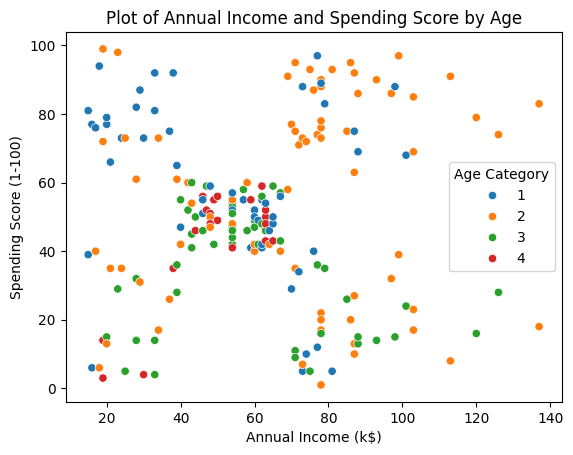

In [ ]:
# Plot the distribution of the annual income and spending score
sns.scatterplot(data=customer_df,
                x='Annual Income (k$)', 
                y='Spending Score (1-100)', 
                hue='Age Category', 
                palette='tab10'
)

plt.title('Plot of Annual Income and Spending Score by Age')
plt.show()

#### **Data Preprocessing**

In [149]:
# Drop unnecessary columns
customer_df.drop(columns=['CustomerID', 'Age', 'Gender', 'Age Category'], inplace=True)
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Annual Income (k$)      200 non-null    int64
 1   Spending Score (1-100)  200 non-null    int64
dtypes: int64(2)
memory usage: 3.3 KB


In [150]:
# Standardize the numerical features
std_scaler = StandardScaler()
columns = customer_df.columns
customer_df[columns] = std_scaler.fit_transform(customer_df)
customer_df.head()

,Annual Income (k$),Spending Score (1-100)
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


#### **Model Training**

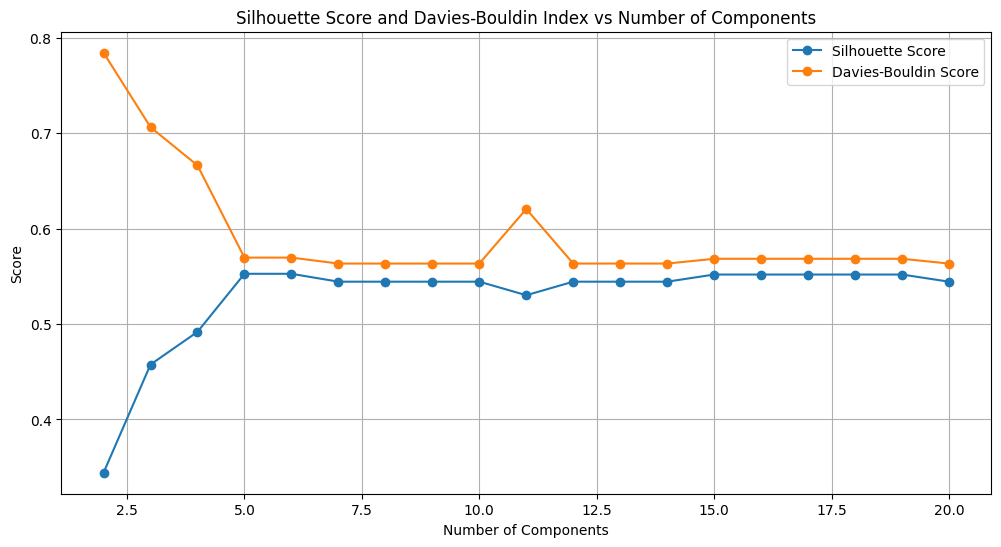

In [151]:
# Calculate the model performance metrics over different values of n_components
n_components = range(2, 21)
results_df = pd.DataFrame({'Components': [], 'Silhouette Score': [], 'Davies-Bouldin Score': []})

# Iterate over different values of n_components
for n in n_components:
    estimator_model = BayesianGaussianMixture(n_components=n, covariance_type='diag', random_state=42)
    estimator_model.fit(customer_df)
    test_cluster_labels = estimator_model.fit_predict(customer_df)
    
    sil_score = silhouette_score(X=customer_df, labels=test_cluster_labels)
    db_score = davies_bouldin_score(X=customer_df, labels=test_cluster_labels)
    
    results_df.loc[n-2, 'Components'] = n
    results_df.loc[n-2, 'Silhouette Score'] = sil_score
    results_df.loc[n-2, 'Davies-Bouldin Score'] = db_score

# Plot the results in a line chart
plt.figure(figsize=(12, 6))
plt.plot(results_df['Components'], 
         results_df['Silhouette Score'], 
         label='Silhouette Score', 
         marker='o')
plt.plot(results_df['Components'], 
         results_df['Davies-Bouldin Score'], 
         label='Davies-Bouldin Score', 
         marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('Silhouette Score and Davies-Bouldin Index vs Number of Components')
plt.legend()
plt.grid()
plt.show()

In [152]:
# Train the Bayesian Gaussian Mixture model with the optimal number of components
bgm = BayesianGaussianMixture(n_components=5, covariance_type='diag', random_state=42)
bgm.fit(customer_df)

BayesianGaussianMixture(covariance_type='diag', n_components=5, random_state=42)

#### **Model Evaluation**

In [ ]:
# Calculate the model performance metrics
cluster_labels = bgm.fit_predict(customer_df)
customer_df['Mixture Component'] = cluster_labels

sil_score = silhouette_score(X=customer_df, labels=cluster_labels)
db_score = davies_bouldin_score(X=customer_df, labels=cluster_labels)

print(f'Silhouette Score: {sil_score:.4f}')
print(f'Davies-Bouldin Score: {db_score:.4f}')

Silhouette Score: 0.6946
Davies-Bouldin Score: 0.4719


In [154]:
# Create a DataFrame to store the cluster information
clsuter_df = pd.DataFrame({'Component': [], 'Weight': [], 'Size': []})

for k, w in enumerate(bgm.weights_):
    clsuter_df.loc[k, 'Component'] = k
    weight_value = float('%.2f' % (w * 100.0))
    clsuter_df.loc[k, 'Weight'] = weight_value
    clsuter_df.loc[k, 'Size'] = len(customer_df[customer_df['Mixture Component'] == k])

clsuter_df

,Component,Weight,Size
0,0.0,39.24,79.0
1,1.0,20.00,39.0
2,2.0,11.45,22.0
3,3.0,18.37,37.0
4,4.0,10.94,23.0


#### **Model Visualization**

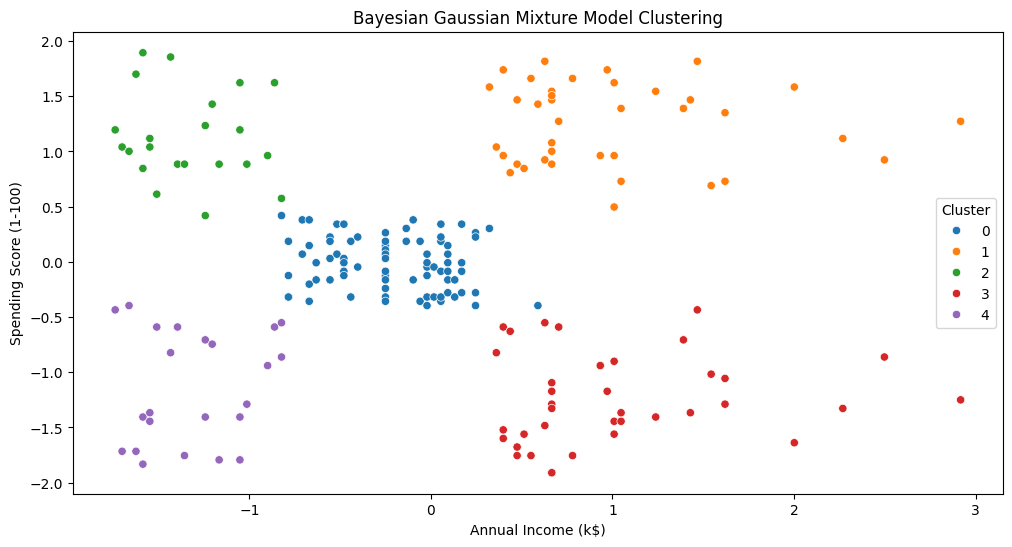

In [155]:
# Plot the distribution of the clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=customer_df,
    x='Annual Income (k$)', 
    y='Spending Score (1-100)', 
    hue='Mixture Component',
    palette='tab10'
)

plt.title('Bayesian Gaussian Mixture Model Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

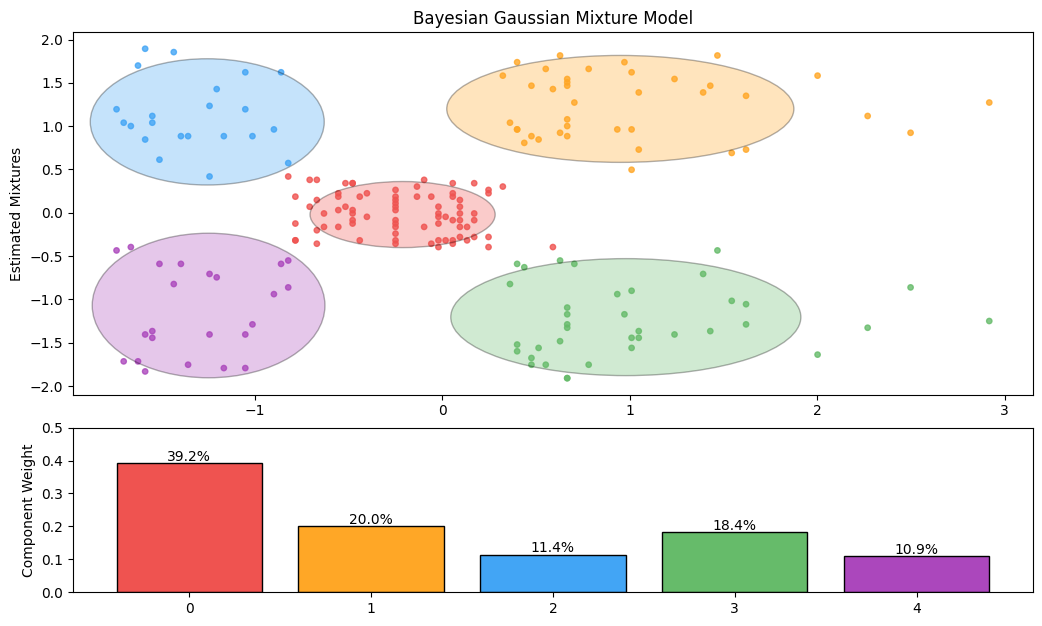

In [ ]:
# Plot the ellipses and the component weights
def plot_ellipses(ax, means, covars):
    for n in range(n_component):
        eig_vals, eig_vecs = np.linalg.eigh(np.diag(covars[n]))
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        angle = 180 * angle / np.pi
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n],
                                  eig_vals[0], 
                                  eig_vals[1], 
                                  angle=180 + angle, 
                                  edgecolor='black')
        ell.set_alpha(0.3)
        ell.set_facecolor(colors[n])
        ax.add_artist(ell)

# Plot the cluster with ellipses and component weights
def plot_results(ax1, ax2, estimator, X):
    ax1.set_title('Bayesian Gaussian Mixture Model', fontsize=12)
    ax1.scatter(X[:, 0], X[:, 1], s=15, color=colors[cluster_labels], alpha=0.8)
    plot_ellipses(ax1, estimator.means_, estimator.covariances_)

    # Plot the component weights
    for k, w in enumerate(estimator.weights_):
        ax2.bar(k, w, width=0.8, color=colors[k], edgecolor='black')
        ax2.text(k, w + 0.007, '%.1f%%' % (w * 100.0), horizontalalignment='center')
        if k + 1 == n_component: break

    ax2.set_ylim(0.0, 0.5)
    ax1.set_ylabel('Estimated Mixtures')
    ax2.set_ylabel('Component Weight')

# Configure the plot layout
plt.figure(figsize=(12, 8))
plt.subplots_adjust(bottom=0.2, top=0.90, hspace=0.2, wspace=0.2, left=0.1, right=0.9)
colors = np.array(['#EF5350', '#FFA726', '#42A5F5', '#66BB6A', '#AB47BC'])
n_component = customer_df['Mixture Component'].nunique()
gs = gridspec.GridSpec(3, 1)

plot_results(plt.subplot(gs[:2, 0]), plt.subplot(gs[2, 0]), bgm, customer_df.values)
plt.show()

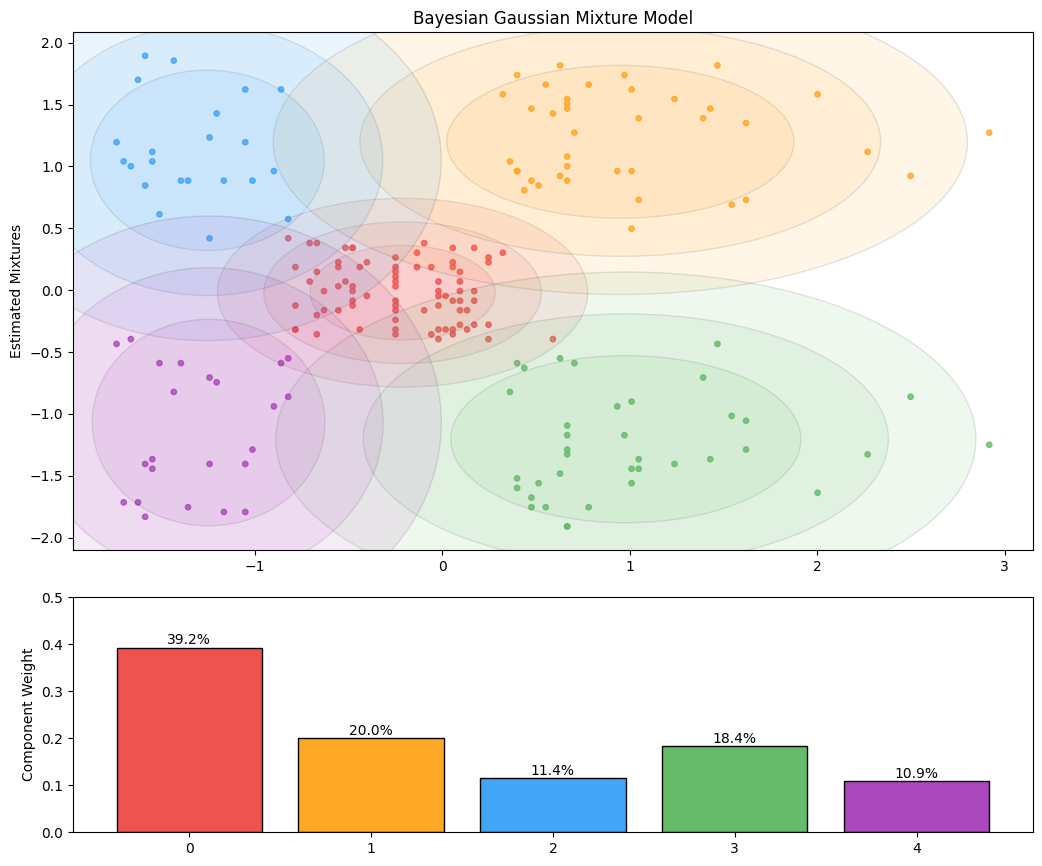

In [ ]:
# Plot the ellipses and the component weights
def plot_ellipses(ax, means, covars, colors):
    for n in range(n_component):
        covar = np.diag(covars[n])
        eig_vals, eig_vecs = np.linalg.eigh(covar)
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        angle = 180 * angle / np.pi
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        
        # Plot the ellipses with different scales
        for scale in [1.0, 1.5, 2.0]:
            ell = mpl.patches.Ellipse(means[n], 
                                      scale * eig_vals[0], 
                                      scale * eig_vals[1], 
                                      angle=180 + angle, 
                                      edgecolor='black')
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.1)
            ell.set_facecolor(colors[n % len(colors)])
            ax.add_artist(ell)

# Plot the cluster with ellipses and component weights
def plot_results(ax1, ax2, estimator, X, cluster_labels, colors):
    ax1.set_title('Bayesian Gaussian Mixture Model', fontsize=12)
    ax1.scatter(X[:, 0], X[:, 1], s=15, color=colors[cluster_labels], alpha=0.8)
    plot_ellipses(ax1, estimator.means_, estimator.covariances_, colors)

    # Plot the component weights
    for k, w in enumerate(estimator.weights_):
        ax2.bar(k, w, width=0.8, color=colors[k % len(colors)], edgecolor='black')
        ax2.text(k, w + 0.007, '%.1f%%' % (w * 100.0), horizontalalignment='center')
        if k + 1 == n_component: break

    ax2.set_ylim(0.0, 0.5)
    ax1.set_ylabel('Estimated Mixtures')
    ax2.set_ylabel('Component Weight')

# Configure the plot layout
plt.figure(figsize=(12, 8))
plt.subplots_adjust(bottom=0.2, top=1.2, hspace=0.2, wspace=0.2, left=0.1, right=0.9)
colors = np.array(['#EF5350', '#FFA726', '#42A5F5', '#66BB6A', '#AB47BC'])
gs = gridspec.GridSpec(3, 1)

plot_results(
    plt.subplot(gs[:2, 0]),
    plt.subplot(gs[2, 0]),
    bgm,
    customer_df.values,
    cluster_labels,
    colors
)
plt.show()